### Data Preparation

In [41]:
import os
from docx import Document
import re

def load_docx(file_path):
    """Load a .docx file and return the text."""
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

def clean_text(text):
    """Perform basic cleaning of the text."""
    # Remove any new lines and extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text

# Define the paths to your .docx files
file_paths = {
    'Hindu': r'Insert file path here',
    'Norse': r'Insert file path here',
    'Greek': r'Insert file path here'

# Load and clean texts
texts = {}
for mythology, path in file_paths.items():
    raw_text = load_docx(path)
    cleaned_text = clean_text(raw_text)
    texts[mythology] = cleaned_text

for mythology, text in texts.items():
    print(f"First 500 characters of {mythology} text:\n{text[:1000]}\n")

First 500 characters of Hindu text:
THE SIVA PURÄNA PART 1 MOTILAL BANARSIDASS PUBLISHERS pvr. LTD. DELHI First Fditjon: 1950 1973. 1977, 1981. 1986. 1990, 1993, 1996, 1999, 2002 ALSO available at: MOTILAL BANARSIDASS 41 UA Bungalow Road. Jawahar Nagar, Delhi 1 10 007 236, 9th Main Block, Jayanagar. Bangalore 560 0 i I 8 Mahalaxmi Chamber, 22 Bhulabhai Desai Road, Mumbai 400 026 120 Royapeuah High Road. Mylapore. Chennai 600 004 Sanas Plaza, 1302 Rao Road, Punc 41 1 002 8 Camac Street, Kolkata 700 017 Ashok Rajpath, Patna 800 004 Chowk, Varanasi 221 001 hinted India BY IAINENDRA PRAKASH JAIN AT SHRI JAINENDRA PRESS. NARAINA. PHASE-I. NEW DELHI 028 AND PUBLISHED BY NARENDRA PRAKASH JAIN FOR MOTILAL BANARSLDASS PUBLISHERS PRIVATE 1M!TED. BUNGALOW ROAD, DEI.HI 007 CONTENTS PAGE RUDRA-SAÜHITÄ SECTION 11 : NARRATIVE OF SATt 26, The cause of estrangement between Dakqa and Siva 395 The inauguration of Dak*a's sacrifice 400 Sati's journey 405 Sati's statement 409 Sati's casting-off of her body

### Tokenizing texts and labelling sentences by mythology

In [42]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

# Assuming texts is a dictionary with keys 'Hindu', 'Norse', 'Greek' and values as full text of each mythology
texts_sentences = {mythology: sent_tokenize(text) for mythology, text in texts.items()}

# Flatten the list of sentences and create a list of labels indicating the source mythology
all_sentences = []
labels = []
for mythology, sentences in texts_sentences.items():
    all_sentences.extend(sentences)
    labels.extend([mythology] * len(sentences))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Creating the TF-IDF Matrix

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Custom tokenizer to exclude numbers and enforce a minimum word length of 4
def custom_tokenizer(text):
    # Split on non-word characters, exclude purely numerical tokens, and enforce minimum length of 4
    return [token for token in re.split('\W+', text) if token and not token.isdigit() and len(token) >= 4]

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=10,  # Adjust as needed to manage noise
    max_df=0.7,
    stop_words='english',
    tokenizer=custom_tokenizer
)

tfidf_matrix = tfidf_vectorizer.fit_transform(all_sentences)

# Output the shape and some feature names to inspect
print("Shape of the TF-IDF Matrix:", tfidf_matrix.shape)
print("feature names:", tfidf_vectorizer.get_feature_names_out()[:100])

Shape of the TF-IDF Matrix: (9062, 1530)
feature names: ['abandoned' 'abducted' 'abduction' 'able' 'acamas' 'acastos' 'accept'
 'accepted' 'accidentally' 'accompanied' 'accordance' 'according'
 'account' 'accounts' 'acheloos' 'achilles' 'acousilaos' 'acquired'
 'acrisios' 'acropolis' 'actaion' 'action' 'actor' 'added' 'addition'
 'admetos' 'adonis' 'adopted' 'adrastos' 'adventures' 'advice' 'advised'
 'aegina' 'aeneas' 'aerope' 'aesch' 'aetolia' 'afraid' 'agamemnon'
 'agenor' 'agreed' 'agrios' 'ahead' 'aiacos' 'aias' 'aietes' 'aigeus'
 'aigimios' 'aigisthos' 'aigyptos' 'aiolos' 'aison' 'aithra' 'alcestis'
 'alcmaion' 'alcmene' 'alcyone' 'aleos' 'alexander' 'alive' 'allies'
 'allow' 'allowed' 'ally' 'aloads' 'altar' 'alternative' 'althaia'
 'amaltheia' 'amazon' 'amazons' 'ambush' 'amphiaraos' 'amphilochos'
 'amphion' 'amphitryon' 'ancient' 'andraimon' 'androgeos' 'anger'
 'angered' 'angry' 'answer' 'answered' 'antenor' 'antiope' 'antiphos'
 'apart' 'aphareus' 'aphrodite' 'apollo' 'apoll

C:\Users\abuba\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Creating clusters using the TF-IDF Matrix

In [44]:
# Continue with clustering
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Function to find top terms per cluster
def get_top_terms_per_cluster(tfidf_vectorizer, kmeans_model, num_terms=10):
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    top_terms = {i: [terms[ind] for ind in order_centroids[i, :num_terms]] for i in range(n_clusters)}
    return top_terms

# Retrieve and display the top terms for each cluster
top_terms_per_cluster = get_top_terms_per_cluster(tfidf_vectorizer, kmeans)
for cluster_num, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster_num}: {', '.join(terms)}")



C:\Users\abuba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: story, came, siva, listen, version, told, listening, hearing, excellent, following
Cluster 1: loki, ütgarö, said, dwarf, th6r, ööin, went, came, good, ring
Cluster 2: daughter, killed, heracles, zeus, sons, went, father, according, gods, king
Cluster 3: called, king, gold, place, daughter, father, ööin, horse, came, earth
Cluster 4: said, high, gangleri, süta, th6r, great, gods, daughter, zeus, heracles


#### Creating thematic labels using the cluster information

In [45]:
import numpy as np
from collections import Counter


# Assuming we have the 'cluster_labels' from the KMeans clustering output
cluster_labels = kmeans.labels_

# Define a dictionary to map cluster numbers to thematic labels
cluster_to_theme = {
    0: "Narrative",
    1: "Norse Mythology",
    2: "Heroic and Family",
    3: "Royalty and Wealth",
    4: "Divine Discourse"
}

# Map the cluster labels to thematic labels
thematic_labels = [cluster_to_theme[label] for label in cluster_labels]

# prepare the data for training a classification model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'all_sentences' is a list of all text sentences
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(all_sentences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, thematic_labels, test_size=0.2, random_state=42)

# Count the frequency of each cluster label
cluster_counts = Counter(cluster_labels)
thematic_counts = Counter(thematic_labels)

print("Cluster distribution:", cluster_counts)
print("Thematic label distribution:", thematic_counts)

Cluster distribution: Counter({2: 8039, 4: 337, 0: 297, 3: 278, 1: 111})
Thematic label distribution: Counter({'Heroic and Family': 8039, 'Divine Discourse': 337, 'Narrative': 297, 'Royalty and Wealth': 278, 'Norse Mythology': 111})


### Comparing Machine Learning Models for predicting Themes

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict on the test set
logistic_predictions = logistic_model.predict(X_test)

# Print the classification report for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions))

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
forest_predictions = random_forest_model.predict(X_test)

# Print the classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, forest_predictions))


Logistic Regression Classification Report:
                    precision    recall  f1-score   support

  Divine Discourse       0.94      0.81      0.87        63
 Heroic and Family       0.97      1.00      0.99      1619
         Narrative       1.00      0.69      0.81        54
   Norse Mythology       1.00      0.52      0.69        23
Royalty and Wealth       0.98      0.76      0.85        54

          accuracy                           0.97      1813
         macro avg       0.98      0.76      0.84      1813
      weighted avg       0.97      0.97      0.97      1813

Random Forest Classification Report:
                    precision    recall  f1-score   support

  Divine Discourse       0.97      1.00      0.98        63
 Heroic and Family       1.00      1.00      1.00      1619
         Narrative       0.93      0.98      0.95        54
   Norse Mythology       1.00      0.91      0.95        23
Royalty and Wealth       0.98      0.96      0.97        54

          accur

### Chi square test for similiarities/differences and Visualization

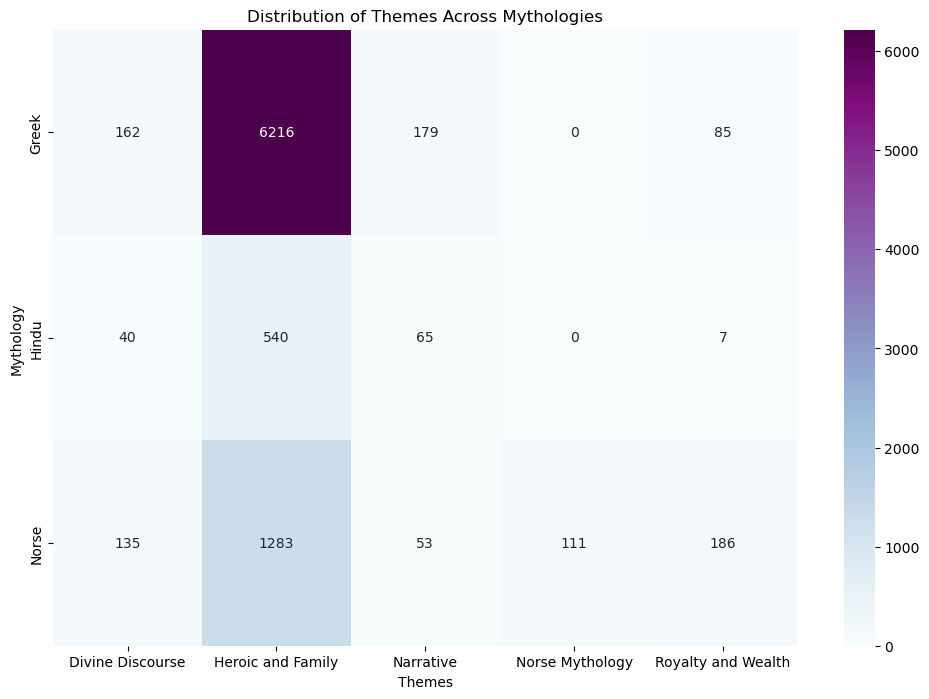

Chi-square test p-value: 4.3228926530807477e-240
Significant differences in theme distribution across mythologies.


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#'thematic_labels' and 'labels' (source mythology) are already defined
# Create a DataFrame for analysis
data = pd.DataFrame({
    'Mythology': labels,
    'Theme': thematic_labels
})

# Calculate theme distribution by mythology
theme_distribution = pd.crosstab(data['Mythology'], data['Theme'])

# Visualize the distribution of themes across mythologies
plt.figure(figsize=(12, 8))
sns.heatmap(theme_distribution, annot=True, cmap="BuPu", fmt='d')
plt.title('Distribution of Themes Across Mythologies')
plt.ylabel('Mythology')
plt.xlabel('Themes')
plt.show()

# Perform Chi-square test for independence
chi2, p, dof, expected = chi2_contingency(theme_distribution)
print(f"Chi-square test p-value: {p}")

# Interpret the results
if p < 0.05:
    print("Significant differences in theme distribution across mythologies.")
else:
    print("No significant differences in theme distribution across mythologies.")


### Installing Textblob

In [48]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def download_nltk_corpora():
    import nltk
    nltk.download('punkt')

# Install TextBlob
install('textblob')

# Download the necessary NLTK corpora used by TextBlob
download_nltk_corpora()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Sentiment Analysis and Visualization

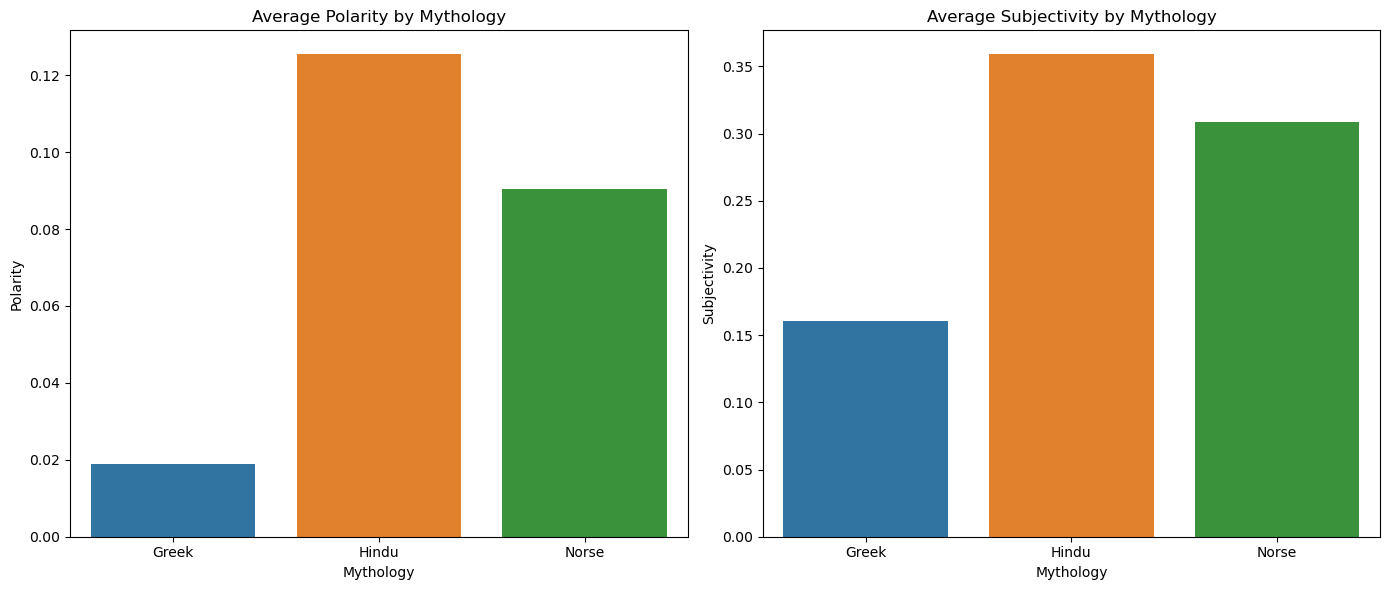

In [49]:
from textblob import TextBlob

# Create a function to analyze sentiment
def analyze_sentiment(text):
    return TextBlob(text).sentiment

# Apply the sentiment analysis function to each sentence
sentiments = [analyze_sentiment(sentence) for sentence in all_sentences]

# Add sentiment data to your DataFrame
data['Polarity'] = [sentiment.polarity for sentiment in sentiments]
data['Subjectivity'] = [sentiment.subjectivity for sentiment in sentiments]

# Calculate average sentiment by mythology
average_sentiment = data.groupby('Mythology').agg({'Polarity': 'mean', 'Subjectivity': 'mean'}).reset_index()

# Visualize the average sentiment by mythology
plt.figure(figsize=(14, 6))

# Polarity
plt.subplot(1, 2, 1)
sns.barplot(x='Mythology', y='Polarity', data=average_sentiment)
plt.title('Average Polarity by Mythology')

# Subjectivity
plt.subplot(1, 2, 2)
sns.barplot(x='Mythology', y='Subjectivity', data=average_sentiment)
plt.title('Average Subjectivity by Mythology')

plt.tight_layout()
plt.show()
